# Joint BRCA2 and SMN1 analysis

In [1]:
# Standard header
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import pdb
import seaborn as sns

# Special imports
from glob import glob
import re
import subprocess
import string
from scipy.stats import pearsonr

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
def load_counts_data(name,libs,reps):
    # Initialize data frame
    counts_df = pd.DataFrame()
    
    if type(libs)==int:
        libs = range(1,libs+1)
    if type(reps)==int:
        reps = range(1,reps+1)
    
    # Merge data frames
    for lib_num in libs:
        for rep_num in reps:
            for rna_type in ['total','exon']:
                counts_file = 'data_%s/%s_lib%d_rep%d_ss_%s.txt'%(name,name,lib_num,rep_num,rna_type)
                col_name = '%s_lib%d_rep%d_%s_ct'%(name,lib_num,rep_num,rna_type)
                print 'Loading data from %s into column %s...'%(counts_file,col_name)
                these_counts_df = pd.read_csv(counts_file,delim_whitespace=True)
                these_counts_df = these_counts_df[['seq','ct']]
                these_counts_df.rename(columns={'ct':col_name},inplace=True)
                if counts_df.empty:
                    counts_df = these_counts_df
                else:
                    counts_df = counts_df.merge(these_counts_df,on='seq',how='outer') 
    
    # Remove invalid splice sites
    rows = [(ss[3:5]=='GT' or ss[3:5]=='GC') for ss in counts_df['seq']]
    counts_df = counts_df.loc[rows,:]
    return counts_df

In [3]:
# Load data
def load_ratios(name,libs,reps,pseudocount=1.0):
    # Initialize data frame
    ratio_df = pd.DataFrame()
    
    if type(libs)==int:
        libs = range(1,libs+1)
    if type(reps)==int:
        reps = range(1,reps+1)
    
    # Merge data frames
    for lib_num in libs:
        for rep_num in reps:
            # Load counts
            this_ratio_df = load_counts_data(name,libs=[lib_num],reps=[rep_num])
            exon_col_name = '%s_lib%d_rep%d_exon_ct'%(name,lib_num,rep_num)
            total_col_name = '%s_lib%d_rep%d_total_ct'%(name,lib_num,rep_num)
            ratio_col_name = '%s_lib%d_rep%d_ratio'%(name,lib_num,rep_num)
            this_ratio_df[ratio_col_name] = \
                (this_ratio_df[exon_col_name]+pseudocount) / (this_ratio_df[total_col_name]+pseudocount)
            del this_ratio_df[exon_col_name]
            del this_ratio_df[total_col_name]
            if ratio_df.empty:
                ratio_df = this_ratio_df
            else:
                ratio_df = ratio_df.merge(this_ratio_df,on='seq',how='outer') 
    
    # Remove invalid splice sites
    rows = [(ss[3:5]=='GT' or ss[3:5]=='GC') for ss in ratio_df['seq']]
    ratio_df = ratio_df.loc[rows,:]
    
    ratio_df.set_index('seq',drop='True',inplace=True)
    return ratio_df

In [4]:
brca2_ratio_df = load_ratios('brca2_9nt',libs=2,reps=3)
brca2_ratio_df.head()

Loading data from data_brca2_9nt/brca2_9nt_lib1_rep1_ss_total.txt into column brca2_9nt_lib1_rep1_total_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib1_rep1_ss_exon.txt into column brca2_9nt_lib1_rep1_exon_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib1_rep2_ss_total.txt into column brca2_9nt_lib1_rep2_total_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib1_rep2_ss_exon.txt into column brca2_9nt_lib1_rep2_exon_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib1_rep3_ss_total.txt into column brca2_9nt_lib1_rep3_total_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib1_rep3_ss_exon.txt into column brca2_9nt_lib1_rep3_exon_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib2_rep1_ss_total.txt into column brca2_9nt_lib2_rep1_total_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib2_rep1_ss_exon.txt into column brca2_9nt_lib2_rep1_exon_ct...
Loading data from data_brca2_9nt/brca2_9nt_lib2_rep2_ss_total.txt into column brca2_9nt_lib2_rep2_total_ct...
Loading data from 

,brca2_9nt_lib1_rep1_ratio,brca2_9nt_lib1_rep2_ratio,brca2_9nt_lib1_rep3_ratio,brca2_9nt_lib2_rep1_ratio,brca2_9nt_lib2_rep2_ratio,brca2_9nt_lib2_rep3_ratio
seq,,,,,,
ACGGTCCAT,0.041640,0.068738,0.157676,0.054983,0.062921,0.382771
ATTGCCAGG,0.076823,0.151316,0.200447,0.198986,0.166443,0.411273
ACAGCGGTA,0.273288,0.332178,0.455556,0.618343,0.528107,0.628468
AAGGTGGGA,7.887314,11.309231,10.754286,17.692913,17.695748,10.224478
ACGGCTTGG,0.043232,0.073359,0.145624,0.069486,0.064565,0.333717


In [5]:
smn1_ratio_df = load_ratios('smn1_9nt',libs=3,reps=3)
smn1_ratio_df.head()

Loading data from data_smn1_9nt/smn1_9nt_lib1_rep1_ss_total.txt into column smn1_9nt_lib1_rep1_total_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib1_rep1_ss_exon.txt into column smn1_9nt_lib1_rep1_exon_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib1_rep2_ss_total.txt into column smn1_9nt_lib1_rep2_total_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib1_rep2_ss_exon.txt into column smn1_9nt_lib1_rep2_exon_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib1_rep3_ss_total.txt into column smn1_9nt_lib1_rep3_total_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib1_rep3_ss_exon.txt into column smn1_9nt_lib1_rep3_exon_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib2_rep1_ss_total.txt into column smn1_9nt_lib2_rep1_total_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib2_rep1_ss_exon.txt into column smn1_9nt_lib2_rep1_exon_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib2_rep2_ss_total.txt into column smn1_9nt_lib2_rep2_total_ct...
Loading data from data_smn1_9nt/smn1_9nt_lib2

,smn1_9nt_lib1_rep1_ratio,smn1_9nt_lib1_rep2_ratio,smn1_9nt_lib1_rep3_ratio,smn1_9nt_lib2_rep1_ratio,smn1_9nt_lib2_rep2_ratio,smn1_9nt_lib2_rep3_ratio,smn1_9nt_lib3_rep1_ratio,smn1_9nt_lib3_rep2_ratio,smn1_9nt_lib3_rep3_ratio
seq,,,,,,,,,
CGAGCTTGC,0.013441,0.088769,0.038621,0.054217,0.014045,0.020921,0.044643,1.047619,0.026549
ATTGCATAA,NaN,0.009138,0.006502,0.029900,0.006702,0.009259,0.005089,0.169811,0.015038
CTGGTAAGT,0.684211,5.625210,2.489260,7.128440,2.721186,2.318898,3.254854,73.928571,100.928571
CAAGTAATC,0.020370,0.204513,0.122075,0.490196,0.148438,0.200000,0.227273,2.875000,2.000000
TATGCTGAT,NaN,0.018767,0.012658,0.007843,0.010955,0.009646,0.012165,0.090909,0.011278


In [6]:
ratios_df = smn1_ratio_df.merge(brca2_ratio_df,left_index=True,right_index=True,how='outer')
ratios_df.head()

,smn1_9nt_lib1_rep1_ratio,smn1_9nt_lib1_rep2_ratio,smn1_9nt_lib1_rep3_ratio,smn1_9nt_lib2_rep1_ratio,smn1_9nt_lib2_rep2_ratio,smn1_9nt_lib2_rep3_ratio,smn1_9nt_lib3_rep1_ratio,smn1_9nt_lib3_rep2_ratio,smn1_9nt_lib3_rep3_ratio,brca2_9nt_lib1_rep1_ratio,brca2_9nt_lib1_rep2_ratio,brca2_9nt_lib1_rep3_ratio,brca2_9nt_lib2_rep1_ratio,brca2_9nt_lib2_rep2_ratio,brca2_9nt_lib2_rep3_ratio
seq,,,,,,,,,,,,,,,
AAAGCAAAA,NaN,NaN,NaN,0.018868,0.013514,0.013953,0.012658,0.076923,NaN,0.028037,0.049020,0.071429,0.108571,0.058065,0.432292
AAAGCAAAC,NaN,0.036145,0.021583,0.044944,0.021858,NaN,0.029197,0.212121,0.032520,0.072165,0.055046,0.177778,0.183673,NaN,0.448276
AAAGCAAAG,NaN,0.072289,NaN,0.029412,0.027211,0.034483,0.008696,0.069767,0.014925,0.111111,0.074468,0.183486,0.028169,NaN,0.348624
AAAGCAAAT,NaN,0.016393,0.017192,0.012945,0.009124,0.011429,0.006652,0.159091,0.028302,0.048232,0.061017,0.160714,0.051852,NaN,0.289216
AAAGCAACA,NaN,0.024096,NaN,0.105263,0.019802,NaN,0.021277,0.421053,0.035294,0.052083,0.081633,0.113475,0.078947,0.032000,0.253968


In [7]:
def sample_correlations(ratios_df, samples, min_ratio=.5, clone_file='data_clones/clones.txt'):
    """Compute correlations between specified samples"""
    n = len(samples)
    k=1
    rhos = np.zeros([n,n])
                
    # Load calibration data
    clones_df = pd.read_csv(clone_file, delim_whitespace=True)
    
    # Get a list of 11nt splice sites with 100% inclusion
    ss_11nt_top = clones_df['ss'][clones_df['incl_pct']==100]

    # Now isolate clones that correspond to just 9 nt variants
    ss_9nt_100pct = [ss[:-2] for ss in ss_11nt_top if ss[-2:]=='TT']

    print ss_9nt_100pct
        
    for i in range(n):
        for j in range(n):
            sample_x = samples[i]
            sample_y = samples[j]
                        
            # Get median of full inclusion clones
            ratio_libX_100pct = np.mean(ratios_df[sample_x][ss_9nt_100pct])
            ratio_libY_100pct = np.mean(ratios_df[sample_y][ss_9nt_100pct])
                
            #assert ~np.isnan(ratio_libX_100pct)
                
            x = ratios_df[sample_x]/ratio_libX_100pct
            y = ratios_df[sample_y]/ratio_libY_100pct
                        
            indices = np.isreal(x.values) & np.isreal(y.values) & (x.values >= min_ratio) & (y.values >= min_ratio)
                        
            #nas = np.logical_or(np.isnan(x.values), np.isnan(y.values))
            rho, p = pearsonr(x.values[indices],y.values[indices])
            rhos[i,j] = rho
    return rhos
            
def plot_sample_correlations(title,ratios_df,min_ratio=0,clim=[0,1]):
    """ Plot correlations between specified samples"""
    plt.figure(figsize=[8,8])
    sns.reset_orig()
    samples = ratios_df.columns
    rhos = sample_correlations(ratios_df,samples,min_ratio=min_ratio)
    plt.imshow(rhos**2,interpolation='nearest',clim=clim)
    plt.colorbar()
    n = len(samples)
    plt.xticks(range(n), samples, rotation='vertical',fontsize=20)
    plt.yticks(range(n), samples,fontsize=20)
    plt.title('%s: $R^2$ coefficients'%title)
    plt.set_cmap('Spectral')
    plt.tight_layout()

['CAGGCAAGT', 'CAGGTAAGT', 'CAGGTAAAT', 'GAGGCAAGT', 'CAGGCGAGT']


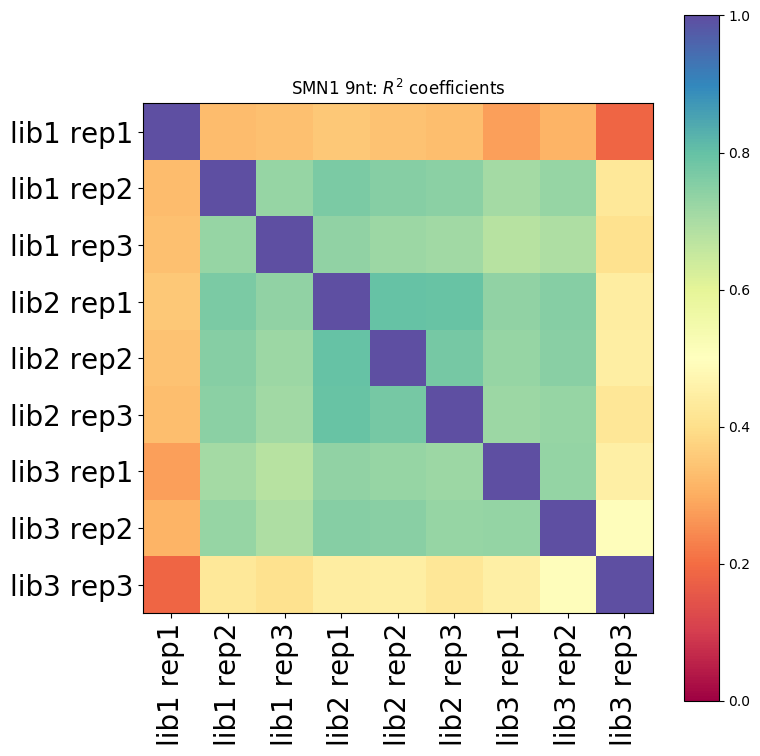

In [8]:
smn1_9nt_samples = [name for name in ratios_df.columns.values if 'smn1_9nt' in name] 
smn1_9nt_df = ratios_df[smn1_9nt_samples]
smn1_9nt_df.columns = [' '.join(x.split('_')[2:4]) for x in smn1_9nt_df.columns]
plot_sample_correlations('SMN1 9nt',smn1_9nt_df,min_ratio=0.0,clim=[0,1])
plt.savefig('smn1_9nt_crosscorr.png')

['CAGGCAAGT', 'CAGGTAAGT', 'CAGGTAAAT', 'GAGGCAAGT', 'CAGGCGAGT']


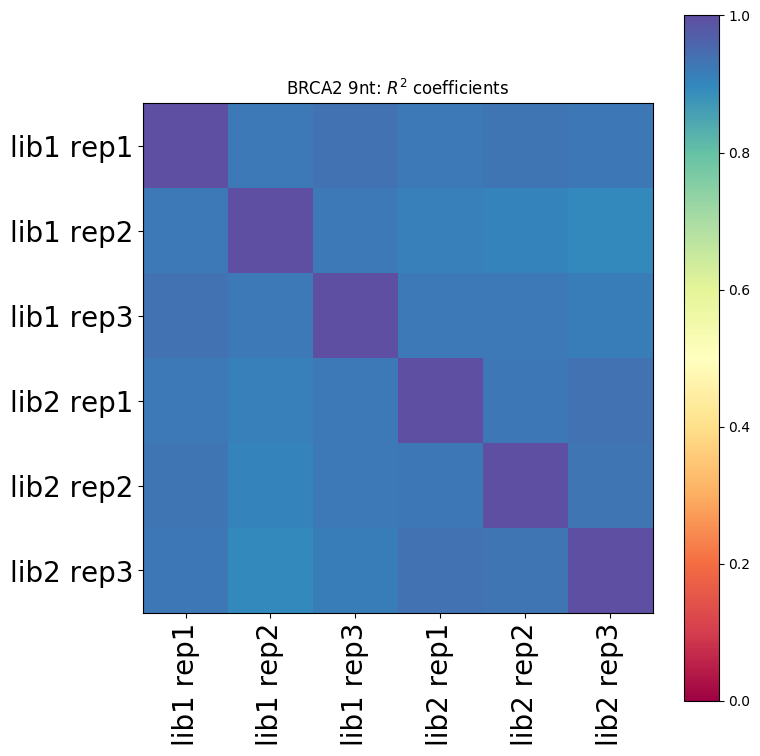

In [9]:
brca2_9nt_samples = [name for name in ratios_df.columns.values if 'brca2_9nt' in name] 
brca2_9nt_df = ratios_df[brca2_9nt_samples]
brca2_9nt_df.columns = [' '.join(x.split('_')[2:4]) for x in brca2_9nt_df.columns]
plot_sample_correlations('BRCA2 9nt',brca2_9nt_df,min_ratio=0.0,clim=[0,1])
plt.savefig('brca2_9nt_crosscorr.png')

['CAGGCAAGT', 'CAGGTAAGT', 'CAGGTAAAT', 'GAGGCAAGT', 'CAGGCGAGT']


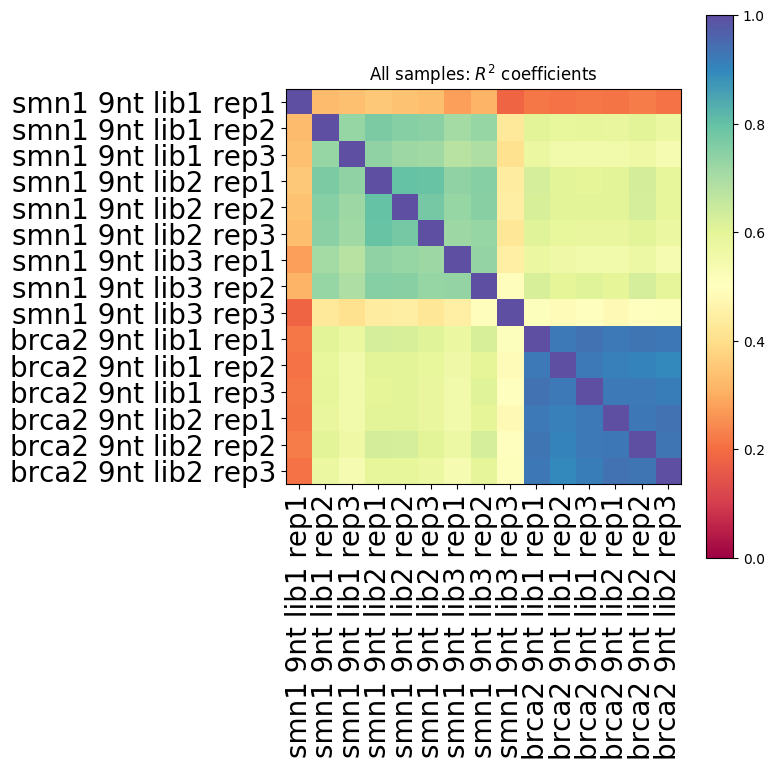

In [10]:
all_samples = [name for name in ratios_df.columns.values if '9nt' in name] 
all_df = ratios_df[all_samples]
all_df.columns = [' '.join(x.split('_')[0:4]) for x in all_df.columns]
plot_sample_correlations('All samples',all_df,min_ratio=0.0,clim=[0,1])
plt.savefig('all_crosscorr.png')

In [11]:
# Load calibration data
clone_file='data_clones/clones.txt'
clones_df = pd.read_csv(clone_file, delim_whitespace=True)

# Get a list of 11nt splice sites with 100% inclusion
ss_11nt_top = clones_df['ss'][clones_df['incl_pct']==100]

# Now isolate clones that correspond to just 9 nt variants
ss_9nt_100pct = [ss[:-2] for ss in ss_11nt_top if ss[-2:]=='TT']

#brca2_100pct = np.median(ratios_df['brca2_9nt_lib1_rep1_ratio'][ss_9nt_100pct])
#smn1_100pct = np.median(ratios_df['smn2_9nt_lib1_rep1_ratio'][ss_9nt_100pct])

# Renormalize each replicate independently
all_samples = [name for name in ratios_df.columns.values if '9nt' in name] 
all_df = ratios_df[all_samples]
for col in all_df.columns:
    all_df.loc[:,col] *= 100/np.median(all_df[col][ss_9nt_100pct])
    
all_df.head(20)

,smn1_9nt_lib1_rep1_ratio,smn1_9nt_lib1_rep2_ratio,smn1_9nt_lib1_rep3_ratio,smn1_9nt_lib2_rep1_ratio,smn1_9nt_lib2_rep2_ratio,smn1_9nt_lib2_rep3_ratio,smn1_9nt_lib3_rep1_ratio,smn1_9nt_lib3_rep2_ratio,smn1_9nt_lib3_rep3_ratio,brca2_9nt_lib1_rep1_ratio,brca2_9nt_lib1_rep2_ratio,brca2_9nt_lib1_rep3_ratio,brca2_9nt_lib2_rep1_ratio,brca2_9nt_lib2_rep2_ratio,brca2_9nt_lib2_rep3_ratio
seq,,,,,,,,,,,,,,,
AAAGCAAAA,NaN,NaN,NaN,0.246448,0.450378,0.515286,0.478504,0.100301,NaN,0.283688,0.326550,0.555701,0.466451,0.293227,3.362684
AAAGCAAAC,NaN,0.587818,0.635920,0.587045,0.728480,NaN,1.103703,0.276587,NaN,0.730181,0.366695,1.383078,0.789108,NaN,3.487021
AAAGCAAAG,NaN,1.175637,NaN,0.384169,0.906883,1.273408,0.328712,0.090971,NaN,1.124247,0.496078,1.427489,0.121021,NaN,2.711854
AAAGCAAAT,NaN,0.266606,0.506549,0.169084,0.304087,0.422044,0.251453,0.207441,NaN,0.488017,0.406472,1.250328,0.222769,NaN,2.249733
AAAGCAACA,NaN,0.391879,NaN,1.374921,0.659960,NaN,0.804294,0.549015,NaN,0.526991,0.543806,0.882816,0.339178,0.161601,1.975553
AAAGCAACC,NaN,0.396658,NaN,0.602850,0.275438,0.439629,NaN,0.325978,NaN,0.481820,0.710573,0.622385,0.186794,0.805076,3.680263
AAAGCAACG,28.235294,19.244521,9.709821,4.353917,5.332474,7.640449,3.566211,2.437748,NaN,26.138734,34.048280,48.474241,0.660962,NaN,8.643042
AAAGCAACT,4.660194,0.631572,0.605431,0.544240,0.634818,1.468761,1.050051,0.448220,NaN,0.580554,0.773224,1.257344,0.252721,0.412247,2.845880
AAAGCAAGA,8.648649,8.432654,3.466387,4.353917,3.999356,1.943623,5.400262,2.607823,NaN,0.538943,0.411529,1.006480,0.379081,0.291836,2.860967


In [12]:
# Get BRCA2 median ratios
brca2_cols = [c for c in all_df.columns if 'brca2_9nt' in c]
all_df['brca2_median'] = all_df[brca2_cols].median(axis=1,skipna=False)

# Get SMN1 median ratios
smn1_cols = [c for c in all_df.columns if ('smn1_9nt_lib2' in c)]
print smn1_cols
all_df['smn1_median'] = all_df[smn1_cols].median(axis=1,skipna=False)

# Get SMN1 median ratios
smn1_cols_7 = [c for c in all_df.columns if (('smn1_9nt' in c) and (not 'lib1_rep1' in c) and (not 'lib3_rep3' in c))]
print smn1_cols_7
all_df['smn1_median_7'] = all_df[smn1_cols_7].median(axis=1,skipna=False)

# Extract smn1 and brca2 median values. Drop rows with any NaNs
df = all_df[['brca2_median','smn1_median','smn1_median_7']].dropna(axis=0,how='any')

['smn1_9nt_lib2_rep1_ratio', 'smn1_9nt_lib2_rep2_ratio', 'smn1_9nt_lib2_rep3_ratio']
['smn1_9nt_lib1_rep2_ratio', 'smn1_9nt_lib1_rep3_ratio', 'smn1_9nt_lib2_rep1_ratio', 'smn1_9nt_lib2_rep2_ratio', 'smn1_9nt_lib2_rep3_ratio', 'smn1_9nt_lib3_rep1_ratio', 'smn1_9nt_lib3_rep2_ratio']


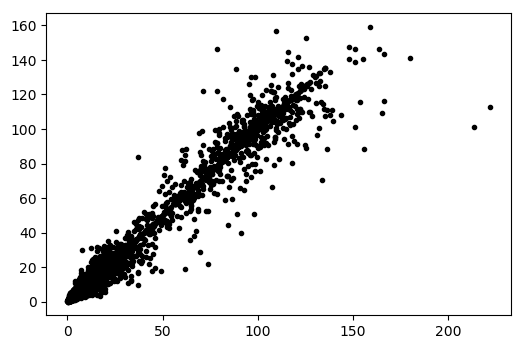

In [13]:
xcol = 'smn1_median'
ycol = 'smn1_median_7'

plt.plot(df[xcol],df[ycol],'.k')

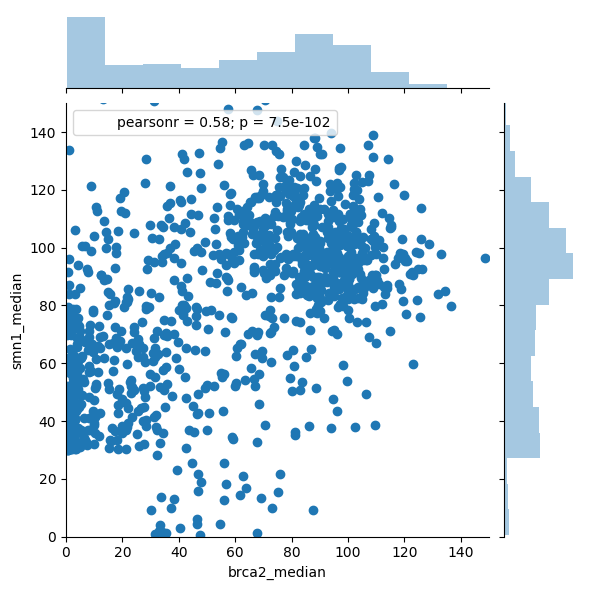

In [14]:
# Keep only rows with sufficient activity in one of the two samples
min_splicing = 30
indices = (df['brca2_median'] > min_splicing) | (df['smn1_median'] > min_splicing )

# Plot splicing levels
sns.jointplot(x='brca2_median',y='smn1_median',data=df[indices],xlim=[0,150],ylim=[0,150],kind='scatter')

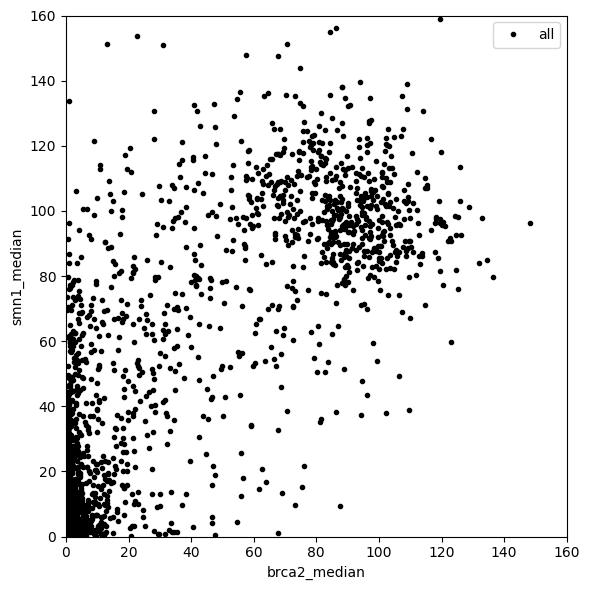

In [15]:
# Identify variants in 3 different regions of the above plot.
# Save plot and 10 seqs from each of the 3 regions
np.random.seed(123)
def get_indices_in_region(in_df,xcol,ycol,x0,y0,dx,dy,num_seqs='all'):
    indices = (abs(in_df[xcol] - x0) < dx) & (abs(in_df[ycol] - y0) < dy)
    out_df = in_df[indices]
    
    if num_seqs == 'all':
        num_seqs = len(out_df)
        print 'Setting num_seqs to %d'%num_seqs
    
    assert len(out_df) > 0, 'No sequences to output'
    
    # Randomize rows and select num_seqs sequences
    if num_seqs > len(out_df):
        num_seqs = len(out_df)
        print "Not enough seqs meeting criteria. Setting num_seqs to %d"%num_seqs
        
    print num_seqs
    indices = range(num_seqs)
    np.random.shuffle(indices)
    out_df = out_df.iloc[indices,:]
    return out_df

xcol = 'brca2_median'
ycol = 'smn1_median'

# df2 = get_indices_in_region(df,xcol=xcol,ycol=ycol,x0=50,y0=50,dx=10,dy=10)
# df3 = get_indices_in_region(df,xcol=xcol,ycol=ycol,x0=0,y0=100,dx=5,dy=20)
# df4 = get_indices_in_region(df,xcol=xcol,ycol=ycol,x0=0,y0=50,dx=2,dy=5)
# df5 = get_indices_in_region(df,xcol=xcol,ycol=ycol,x0=50,y0=0,dx=20,dy=5)

markersize=15
plt.figure(figsize=[6,6])
plt.plot(df[xcol],df[ycol],'.',color='k',label='all')
# if any(df1):
#     df1 = get_indices_in_region(df,xcol=xcol,ycol=ycol,x0=100,y0=100,dx=10,dy=10)
#     plt.plot(df1[xcol],df1[ycol],'.',label='brca2_hi_smn1_hi',markersize=markersize)
#     print '\nBRCA2 hi, SMN1 hi'
#     print df1.head()
#     df1.to_csv('brca2_hi_smn1_hi.csv')
    
# if df2:
#     plt.plot(df2[xcol],df2[ycol],'.',label='brca2_mid_smn1_mid',markersize=markersize)
#     print '\nBRCA2 mid, SMN1 mid'
#     print df2
#     df2.to_csv('brca2_mid_smn1_mid.csv')
    
# if df3:
#     plt.plot(df3[xcol],df3[ycol],'.',label='brca2_low_smn1_hi',markersize=markersize)
#     print '\nBRCA2 low, SMN1 hi'
#     print df3
#     df3.to_csv('brca2_low_smn1_hi.csv')   

# if df4:
#     print '\nBRCA2 low, SMN1 mid'
#     print df4
#     df4.to_csv('brca2_low_smn1_mid.csv')
#     plt.plot(df4[xcol],df4[ycol],'.',label='brca2_low_smn1_mid',markersize=markersize)

# if df5:
#     print '\nBRCA2 mid, SMN1 low'
#     print df5
#     df5.to_csv('brca2_mid_smn1_low.csv')
#     plt.plot(df5[xcol],df5[ycol],'.',label='brca2_mid_smn1_low',markersize=markersize)

plt.xlim([0,160])
plt.ylim([0,160])
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('brca2_smn1_scatter.pdf')

In [16]:
# Extract GC splice sites; index by flanks
indices_gc = np.array([seq[3:5]=='GC' for seq in all_df.index])
gc_df = all_df.loc[indices_gc,['brca2_median']]
flanks = [s[:3]+'..'+s[5:] for s in gc_df.index] 
gc_df['flanks'] = flanks
gc_df.reset_index(inplace=True,drop=False)
gc_df.set_index('flanks',drop=True,inplace=True)
gc_df.rename(columns={'seq':'GC_seq','brca2_median':'brca2_median_GC'},inplace=True)

# Extract GT splice sites; index by flanks
indices_gt = np.array([seq[3:5]=='GT' for seq in all_df.index])
gt_df = all_df.loc[indices_gt,['brca2_median']]
flanks = [s[:3]+'..'+s[5:] for s in gt_df.index] 
gt_df['flanks'] = flanks
gt_df.reset_index(inplace=True,drop=False)
gt_df.set_index('flanks',drop=True,inplace=True)
gt_df.rename(columns={'seq':'GT_seq','brca2_median':'brca2_median_GT'},inplace=True)

# Merge GC and GT dataframes and drop NAN results
gcgt_df = gt_df.merge(gc_df,left_index=True,right_index=True)
gcgt_df.dropna(inplace=True)
print gcgt_df.head()

              GT_seq  brca2_median_GT     GC_seq  brca2_median_GC
flanks                                                           
AAA..AACA  AAAGTAACA         1.193634  AAAGCAACA         0.535398
AAA..AAGA  AAAGTAAGA        67.589574  AAAGCAAGA         0.475236
AAA..AAGG  AAAGTAAGG        62.665403  AAAGCAAGG         1.451451
AAA..AAGT  AAAGTAAGT        75.669587  AAAGCAAGT         1.019879
AAA..AATA  AAAGTAATA         0.842171  AAAGCAATA         0.440656


5
5
5
5
Setting num_seqs to 50
50

brca2_GT_hi_GC_hi
              GT_seq  brca2_median_GT     GC_seq  brca2_median_GC
flanks                                                           
ACG..AAGT  ACGGTAAGT       111.990838  ACGGCAAGT        98.168453
CAG..GAGT  CAGGTGAGT       102.172691  CAGGCGAGT        94.235854
GAG..AAGT  GAGGTAAGT        95.128341  GAGGCAAGT        80.579414
AAG..AAGT  AAGGTAAGT        86.445163  AAGGCAAGT        86.245885
CAG..AAGT  CAGGTAAGT       101.535755  CAGGCAAGT       102.372785

brca2_GT_hi_GC_mid
              GT_seq  brca2_median_GT     GC_seq  brca2_median_GC
flanks                                                           
AAG..AAGA  AAGGTAAGA        88.158527  AAGGCAAGA        43.733601
CTG..AAGT  CTGGTAAGT       108.474503  CTGGCAAGT        41.449625
ATG..AAGT  ATGGTAAGT        89.014227  ATGGCAAGT        47.516345
CAG..AAGG  CAGGTAAGG       107.604162  CAGGCAAGG        56.901353
AAG..AAGC  AAGGTAAGC        89.077469  AAGGCAAGC        50.644318

br

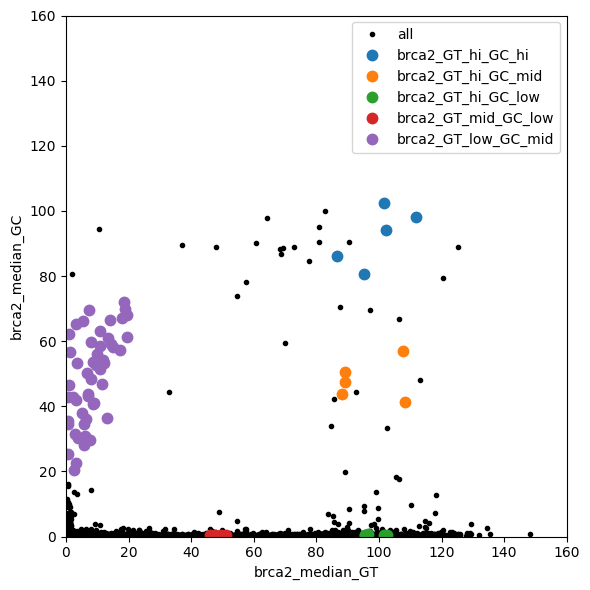

In [17]:
xcol = 'brca2_median_GT'
ycol = 'brca2_median_GC'
df1 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=100,y0=100,dx=20,dy=20,num_seqs=5)
df1_label='brca2_GT_hi_GC_hi'
df2 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=100,y0=50,dx=20,dy=10,num_seqs=5)
df2_label='brca2_GT_hi_GC_mid'
df3 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=100,y0=0,dx=5,dy=5,num_seqs=5)
df3_label='brca2_GT_hi_GC_low'
df4 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=50,y0=0,dx=5,dy=5,num_seqs=5)
df4_label='brca2_GT_mid_GC_low'
df5 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=0,y0=50,dx=20,dy=30,num_seqs='all')
df5_label='brca2_GT_low_GC_mid'


markersize=15
plt.figure(figsize=[6,6])
plt.plot(gcgt_df[xcol],gcgt_df[ycol],'.k',label='all')
plt.plot(df1[xcol],df1[ycol],'.',label=df1_label,markersize=markersize)
plt.plot(df2[xcol],df2[ycol],'.',label=df2_label,markersize=markersize)
plt.plot(df3[xcol],df3[ycol],'.',label=df3_label,markersize=markersize)
plt.plot(df4[xcol],df4[ycol],'.',label=df4_label,markersize=markersize)
plt.plot(df5[xcol],df5[ycol],'.',label=df5_label,markersize=markersize)

plt.xlim([0,160])
plt.ylim([0,160])
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('gc_gt_scatter.pdf')

print '\n'+df1_label
print df1
df1.to_csv(df1_label+'.csv')

print '\n'+df2_label
print df2
df2.to_csv(df2_label+'.csv')

print '\n'+df3_label
print df3
df3.to_csv(df3_label+'.csv')

print '\n'+df4_label
print df4
df4.to_csv(df4_label+'.csv')

print '\n'+df5_label
print df5
df5.to_csv(df5_label+'.csv')

In [18]:
# Extract GC splice sites; index by flanks
indices_gc = np.array([seq[3:5]=='GC' for seq in all_df.index])
gc_df = all_df.loc[indices_gc,['smn1_median']]
flanks = [s[:3]+'..'+s[5:] for s in gc_df.index] 
gc_df['flanks'] = flanks
gc_df.reset_index(inplace=True,drop=False)
gc_df.set_index('flanks',drop=True,inplace=True)
gc_df.rename(columns={'seq':'GC_seq','smn1_median':'smn1_median_GC'},inplace=True)

# Extract GT splice sites; index by flanks
indices_gt = np.array([seq[3:5]=='GT' for seq in all_df.index])
gt_df = all_df.loc[indices_gt,['smn1_median']]
flanks = [s[:3]+'..'+s[5:] for s in gt_df.index] 
gt_df['flanks'] = flanks
gt_df.reset_index(inplace=True,drop=False)
gt_df.set_index('flanks',drop=True,inplace=True)
gt_df.rename(columns={'seq':'GT_seq','smn1_median':'smn1_median_GT'},inplace=True)

# Merge GC and GT dataframes and drop NAN results
gcgt_df = gt_df.merge(gc_df,left_index=True,right_index=True)
gcgt_df.dropna(inplace=True)
print gcgt_df.head()

              GT_seq  smn1_median_GT     GC_seq  smn1_median_GC
flanks                                                         
AAA..AAAA  AAAGTAAAA        0.453442  AAAGCAAAA        0.450378
AAA..AAAG  AAAGTAAAG        0.984105  AAAGCAAAG        0.906883
AAA..AAAT  AAAGTAAAT        0.834939  AAAGCAAAT        0.304087
AAA..AACC  AAAGTAACC        1.119579  AAAGCAACC        0.439629
AAA..AACT  AAAGTAACT        0.475479  AAAGCAACT        0.634818


5
5
5
5

smn1_GT_hi_GC_hi
              GT_seq  smn1_median_GT     GC_seq  smn1_median_GC
flanks                                                         
GGT..GGAA  GGTGTGGAA      105.241944  GGTGCGGAA       97.917376
AAG..AAGG  AAGGTAAGG       96.592779  AAGGCAAGG       96.938202
GGT..GCCA  GGTGTGCCA       91.432266  GGTGCGCCA       92.233202
AAG..AAGT  AAGGTAAGT      102.678259  AAGGCAAGT       98.881707
GGT..GAAT  GGTGTGAAT       99.865075  GGTGCGAAT      102.817662

smn1_GT_hi_GC_low
              GT_seq  smn1_median_GT     GC_seq  smn1_median_GC
flanks                                                         
AAG..AACA  AAGGTAACA      103.443941  AAGGCAACA        0.562497
AAG..AATA  AAGGTAATA       97.420202  AAGGCAATA        0.291074
AAC..ATGT  AACGTATGT       97.790368  AACGCATGT        0.400938
AAC..AAGG  AACGTAAGG       98.097312  AACGCAAGG        3.029815
AAG..ATTT  AAGGTATTT       98.229474  AAGGCATTT        0.466778

smn1_GT_low_GC_hi
              GT_seq  smn1_median_GT    

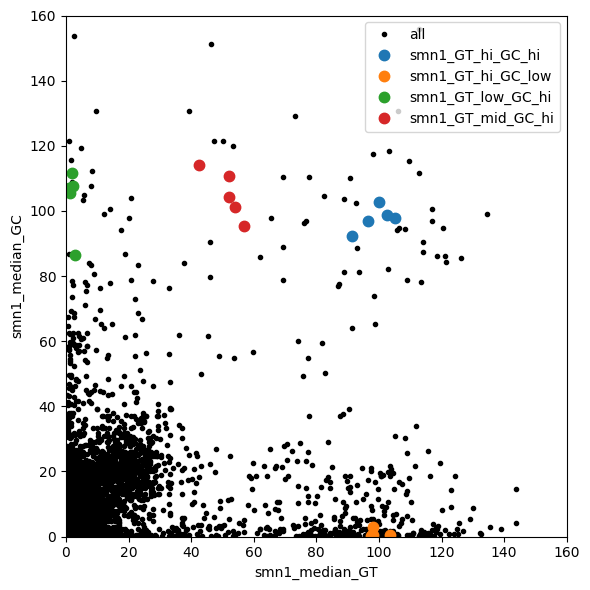

In [19]:
xcol = 'smn1_median_GT'
ycol = 'smn1_median_GC'
df1 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=100,y0=100,dx=10,dy=10,num_seqs=5)
df1_label='smn1_GT_hi_GC_hi'
df2 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=100,y0=0,dx=5,dy=5,num_seqs=5)
df2_label='smn1_GT_hi_GC_low'
df3 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=0,y0=100,dx=5,dy=15,num_seqs=5)
df3_label='smn1_GT_low_GC_hi'
df4 = get_indices_in_region(gcgt_df,xcol=xcol,ycol=ycol,x0=50,y0=100,dx=15,dy=15,num_seqs=5)
df4_label='smn1_GT_mid_GC_hi'


markersize=15
plt.figure(figsize=[6,6])
plt.plot(gcgt_df[xcol],gcgt_df[ycol],'.k',label='all')
plt.plot(df1[xcol],df1[ycol],'.',label=df1_label,markersize=markersize)
plt.plot(df2[xcol],df2[ycol],'.',label=df2_label,markersize=markersize)
plt.plot(df3[xcol],df3[ycol],'.',label=df3_label,markersize=markersize)
plt.plot(df4[xcol],df4[ycol],'.',label=df4_label,markersize=markersize)

plt.xlim([0,160])
plt.ylim([0,160])
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('smn1_gc_gt_scatter.pdf')

print '\n'+df1_label
print df1
df1.to_csv(df1_label+'.csv')

print '\n'+df2_label
print df2
df2.to_csv(df2_label+'.csv')

print '\n'+df3_label
print df3
df3.to_csv(df3_label+'.csv')

print '\n'+df4_label
print df4
df4.to_csv(df4_label+'.csv')

In [20]:
ss_motif = 'NNNGYNNNN'

In [21]:
# Compute MaxEnt scores on all splice sites
import os, sys

def make_iupac_seqs(iupac_motif):
    """Returns a list of all DNA sequences that match an IUPAC motif"""
    iupac_dict = {
        'A':'A',
        'C':'C',
        'G':'G',
        'T':'T',
        'R':'AG',
        'Y':'CT',
        'S':'GC',
        'W':'AT',
        'K':'GT',
        'M':'AC',
        'B':'CGT',
        'D':'AGT',
        'H':'ACT',
        'V':'ACG',
        'N':'ACGT'
        }
    
    if len(iupac_motif) == 0:
        return ['']
    else:
        # Recursively get subseqs
        suffix_seqs = make_iupac_seqs(iupac_motif[1:])
        
        # Get prefix characters
        key = iupac_motif[0]
        assert key in iupac_dict.keys(), 'Invalid character: %s'%key
        prefix_chars = iupac_dict[key]
        
        # Build new sequences
        seqs = [c+s for c in prefix_chars for s in suffix_seqs]
        return seqs
    
seqs = make_iupac_seqs('NNNGYNNNN')
print len(seqs)

32768


In [22]:
import os

# Write all candidate splice sites to file
splice_sites_gt = make_iupac_seqs('NNNGTNNNN') 
f = open('splice_sites.txt','w')
f.write('\n'.join(splice_sites_gt)+'\n')
f.close()

# Run maxentscan
os.chdir('maxentscan')
os.system('perl score5.pl ../splice_sites.txt > ../maxent_scores.txt')
os.chdir('..')

# Load results into dataframe
maxent_df = pd.read_csv('maxent_scores.txt',header=None,names=['seq','maxent'],delim_whitespace=True)
maxent_df.set_index('seq',inplace=True)
maxent_df.head()

,maxent
seq,
AAAGTAAAA,1.18
AAAGTAAAC,1.69
AAAGTAAAG,1.60
AAAGTAAAT,4.06
AAAGTAACA,1.87


In [46]:
# 17.04.17 read in multiple types of scores from MaxEntScan's website
scores_df = pd.read_csv('scored_splice_sites.txt',header=None,delim_whitespace=True)
scores_df.rename(columns={0:'seq',2:'MaxEnt',4:'MDD',6:'MM',8:'WMM'},inplace=True)
scores_df.drop([1,3,5,7], axis=1,inplace=True) 
scores_df.set_index('seq',drop=True,inplace=True)
scores_df.head()

# Extract smn1 and brca2 median values. Drop rows with any NaNs
medians_df = all_df[['brca2_median','smn1_median']].dropna(axis=0,how='any')

# Add in median measurments to scores_df
df = scores_df.merge(medians_df,left_index=True,right_index=True)
df.head()

,MaxEnt,MDD,MM,WMM,brca2_median,smn1_median
seq,,,,,,
AAAGTAAAG,1.60,7.68,4.04,5.15,3.296432,0.984105
AAAGTAAAT,4.06,7.28,4.04,6.09,0.896435,0.834939
AAAGTAACA,1.87,6.58,3.31,4.36,1.193634,0.659444
AAAGTAAGA,6.91,10.88,6.87,8.19,67.589574,117.350881
AAAGTAAGC,7.31,11.98,6.94,8.31,74.625003,133.280599


In [64]:
import os
# Use the Kraskov estimator to compute the amount of mutual information in each relationship
def kraskov_MI(xs,ys,k_neighbors,noise=1E-8):
    N = len(xs)
    assert len(ys) == N
    tmp_df = pd.DataFrame()
    tmp_df['x'] = xs
    tmp_df['y'] = ys
    in_file_name = 'kraskov_input_df.txt'
    out_file_name = 'mi.txt'
    tmp_df.to_csv(in_file_name,sep='\t',header=False,index=False)

    command = """
    ./MIhigherdim %s 2 1 1 %d %d %f > %s
    """%(in_file_name,N,k_neighbors,noise,out_file_name)
    os.system(command)
    
    f = open(out_file_name,'r')
    mi = float(f.readline().strip())
    return mi

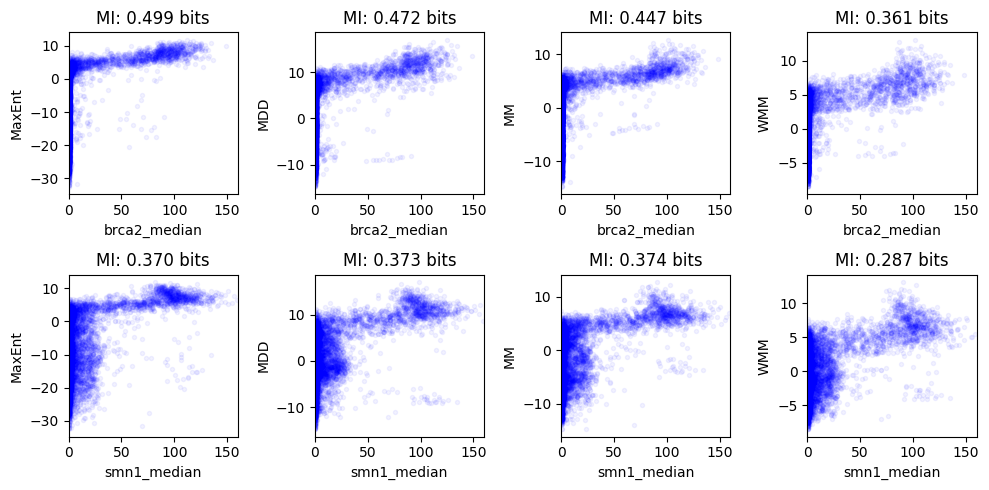

In [73]:
markersize=15
plt.figure(figsize=[10,5])
alpha = 0.05
xl = [0,160]
k_neighbors = 10
noise = 0.01
#yl = [-40,20]

score_cols = ['MaxEnt','MDD','MM','WMM']
K = len(score_cols)
for i, ycol in enumerate(score_cols):
    xcol = 'brca2_median'

    #df1 = get_indices_in_region(scored_df,xcol='smn1_median',ycol=ycol,x0=110,y0=-20,dx=30,dy=10,num_seqs=20)
    #df1_label='smn1_hi_maxent_low'

    # Plot brca2_median vs. maxent
    plt.subplot(2,K,i+1)
    plt.plot(df[xcol],df[ycol],'.b',label='all',alpha=alpha)
    #plt.plot(df1[xcol],df1[ycol],'.',label=df1_label,markersize=markersize)
    plt.xlim(xl)
    #plt.ylim(yl)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    #plt.legend(loc='lower right')
    mi = kraskov_MI(df[xcol],df[ycol],k_neighbors=k_neighbors,noise=noise)
    plt.title('MI: %0.3f bits'%mi)

    # Plot smn1_median vs. maxent
    plt.subplot(2,K,i+1+K)
    xcol = 'smn1_median'
    plt.plot(df[xcol],df[ycol],'.b',label='all',alpha=alpha)
    #plt.plot(df1[xcol],df1[ycol],'.',label=df1_label,markersize=markersize)
    plt.xlim(xl)
    #plt.ylim(yl)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    #plt.legend(loc='lower right')
    mi = kraskov_MI(df[xcol],df[ycol],k_neighbors=k_neighbors,noise=noise)
    plt.title('MI: %0.3f bits'%mi)
    
plt.tight_layout()
plt.savefig('scores_v_measurements.pdf')

#print '\n'+df1_label
#print df1
#df1.to_csv(df1_label+'.csv')

In [56]:
!head kraskov_input_df.csv

1.6	3.29643223773
4.06	0.896435123141
1.87	1.19363373475
6.91	67.5895735829
7.31	74.6250032013
6.6	62.6654030194
9.72	75.669587084
0.92	0.842170919095
1.57	0.913265672632
4.65	5.53646447066
